In [444]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from IPython import display

In [445]:
# Setup the sensor geometry
# All units in mm

sensor = {
    'px': .25e-3,
    'npix':[320, 320]
    }

sensor['fov'] = [sensor['npix'][0]*sensor['px'], sensor['npix'][1]*sensor['px']]


In [446]:
def genz(ii):
    if ii == 1:
        Z = lambda x, y : np.ones_like(x)
        fx = lambda x, y : 0
        fy = lambda x, y : 0
    elif ii == 2:
        Z = lambda x, y : x
        fx = lambda x, y : 1
        fy = lambda x, y : 0
    elif ii == 3:
        Z = lambda x, y : y
        fx = lambda x, y : 0
        fy = lambda x, y : 1        
    elif ii == 4:
        Z = lambda x, y : x**2 - y**2
        fx = lambda x, y : 2*x
        fy = lambda x, y : -2*y
    elif ii == 5:
        Z = lambda x, y : -1 + 2*x**2 + 2*y**2
        fx = lambda x, y : 4*x
        fy = lambda x, y : 4*y
    elif ii == 6:
        Z = lambda x, y : 2*x*y
        fx = lambda x, y : 2*y
        fy = lambda x, y : 2*x
    elif ii == 7:
        Z = lambda x, y : x**3 - 3*x*y**2
        fx = lambda x, y : 3*x**2 - 3*y**2
        fy = lambda x, y : 6*x*y
    elif ii == 8:
        Z = lambda x, y : 3*x**3 + 3*x*y**2 - 2*x
        fx = lambda x, y : 9*x**2 + 3*y**2 - 2
        fy = lambda x, y : 6*x*y
    elif ii == 9:
        Z = lambda x, y : 3*y**3 + 3*x**2*y - 2*y
        fx = lambda x, y : 6*x*y
        fy = lambda x, y : 9*y**2 + 3*x**2 - 2
    elif ii == 10:
        Z = lambda x, y : -y**3 + 3*x**2*y
        fx = lambda x, y : 6*x*y
        fy = lambda x, y : -3*y**2 + 3*x**2
    return Z, fx, fy

In [447]:
def genW(zlist,coeffs):
    W = lambda x,y:sum([genz(zlist[ii])[0](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fx = lambda x,y:sum([genz(zlist[ii])[1](x,y)*coeffs[ii] for ii in range(len(zlist))])
    fy = lambda x,y:sum([genz(zlist[ii])[2](x,y)*coeffs[ii] for ii in range(len(zlist))])
    return W, fx, fy

In [489]:
# Test the generation of wavefronts using zernikes
rx = np.linspace(-1,1,501);
ry = np.linspace(-1,1,501);

[Rx,Ry] = np.meshgrid(rx,ry)

zlist = 1+np.r_[1:10]
zco = np.random.randn(len(zlist))



In [490]:
def genSph(efl):
    # Create function handles for spherical wavefront
    # and derivatives, fx and fy.
    # The curvature is designed so that it focuses at a deistance efl
    Wsph = lambda x,y : efl - efl*np.real(np.sqrt(1 - (x/efl)**2 - (y/efl)**2))
    #fx = lambda x,y: x/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    #fy = lambda x,y: y/np.sqrt(1 - (x/efl)**2 - (y/efl)**2)/efl
    fx = lambda x,y: x/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    fy = lambda x,y: y/(efl * np.sqrt(1 - (y/efl)**2 - (x/efl)**2))
    return Wsph, fx, fy


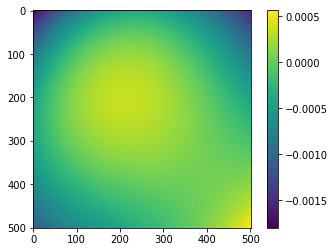

In [493]:
# Construct a wavefront as a surface
# genW creates a list. 0 holds the wavefront, 
# 1 is the x derivative and 2 is the y derivative
zlist = 1+np.r_[1:10]
zco = .0002*np.random.randn(len(zlist))
zco[0] = 0
zco[1] = 0
zco[2] = 0

Wtest, fx, fy = genW(zlist,zco)
out = np.zeros_like(Rx)



plt.figure()
plt.imshow(Wtest(Rx,Ry))
plt.colorbar()



In [494]:

W = genW(zlist, zco)

pupil = {
    'ca':[2, 2],
    'W_aber' : W[0],
    'fx_aber' : W[1],
    'fy_aber' : W[2],
    'efl' : 10,
    't': 10,
    'ap_type' : 'circ'
}
W_sph = genSph(pupil['efl']);
pupil['W_sph'] = W_sph[0]
pupil['fx_sph'] = W_sph[1]
pupil['fy_sph'] = W_sph[2]

In [495]:
# Make a function that can compute a ray's position and OPD at the sensor
def trace_ray(rhox, rhoy, pupil,debug=False):
    W = pupil['W_sph'](rhox,rhoy) + pupil['W_aber'](rhox,rhoy)
    fx = pupil['fx_sph'](rhox,rhoy) + pupil['fx_aber'](rhox,rhoy)
    fy = pupil['fy_sph'](rhox,rhoy) + pupil['fy_aber'](rhox,rhoy)    
    z0 = W - pupil['t']
    nlength = np.sqrt(1 + fx**2 + fy**2)
    K = -fx/nlength
    L = -fy/nlength
    M = 1/nlength
    dz = -z0    
    Delta = dz/M

    
    
    #dy = -dz*fy
    #dx = -dz*fx

    dx = K*Delta
    dy = L*Delta
    
    yo = rhoy + dy
    xo = rhox + dx;
    if debug:
        print('(rhox, rhoy):',rhox,rhoy)
        print('(Fx,Fy)',fx,fy)
        print('(dx, dy, dz)=',dx,dy,dz)        
        print('(xo,yo,zo)',xo,yo,z0)
        print('(K,L,M)=',K,L,M)
        print('Delta:', Delta)
        print('\n')

    
    opl = Delta
    return xo, yo, opl, W, fx, fy, K, L, M

In [510]:
# Rays-only loop
Nrays = 50000
xo = []
yo = []
opl = []
for k in range(Nrays):
    
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = pupil['ca'][1]*(np.random.rand(1) - 0.5)
        rhoy = pupil['ca'][0]*(np.random.rand(1) - 0.5)

    

    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil,debug=False)
    xo.append(rays_out[0])
    yo.append(rays_out[1])
    opl.append(rays_out[2])

    # Create the corresponding plane wave on the sensor grid

    # Add this plane wave to the existing distribution

    # Repeat



In [497]:
#a,b,c,Wt,Fxt,Fyt = trace_ray(Rx,Ry,pupil)

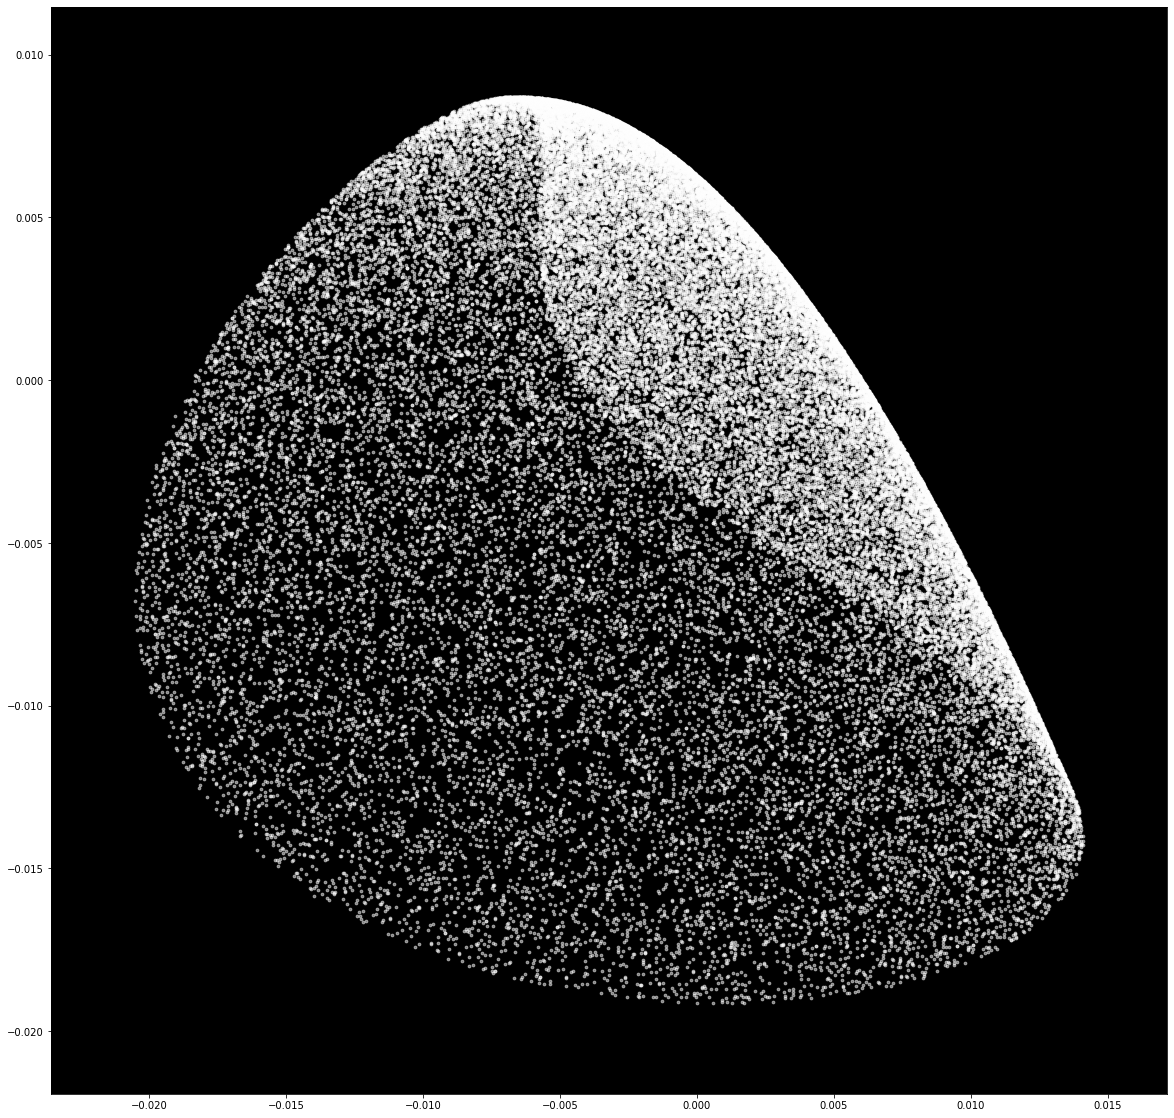

In [512]:
f = plt.figure(figsize=(20,20))
ax = plt.gca()
ax.set_facecolor((0,0,0))
plt.scatter(xo,yo,s=30,c=[[1, 1, 1]],marker='.',alpha=.5)

In [513]:
sensor['fov']

[0.08, 0.08]

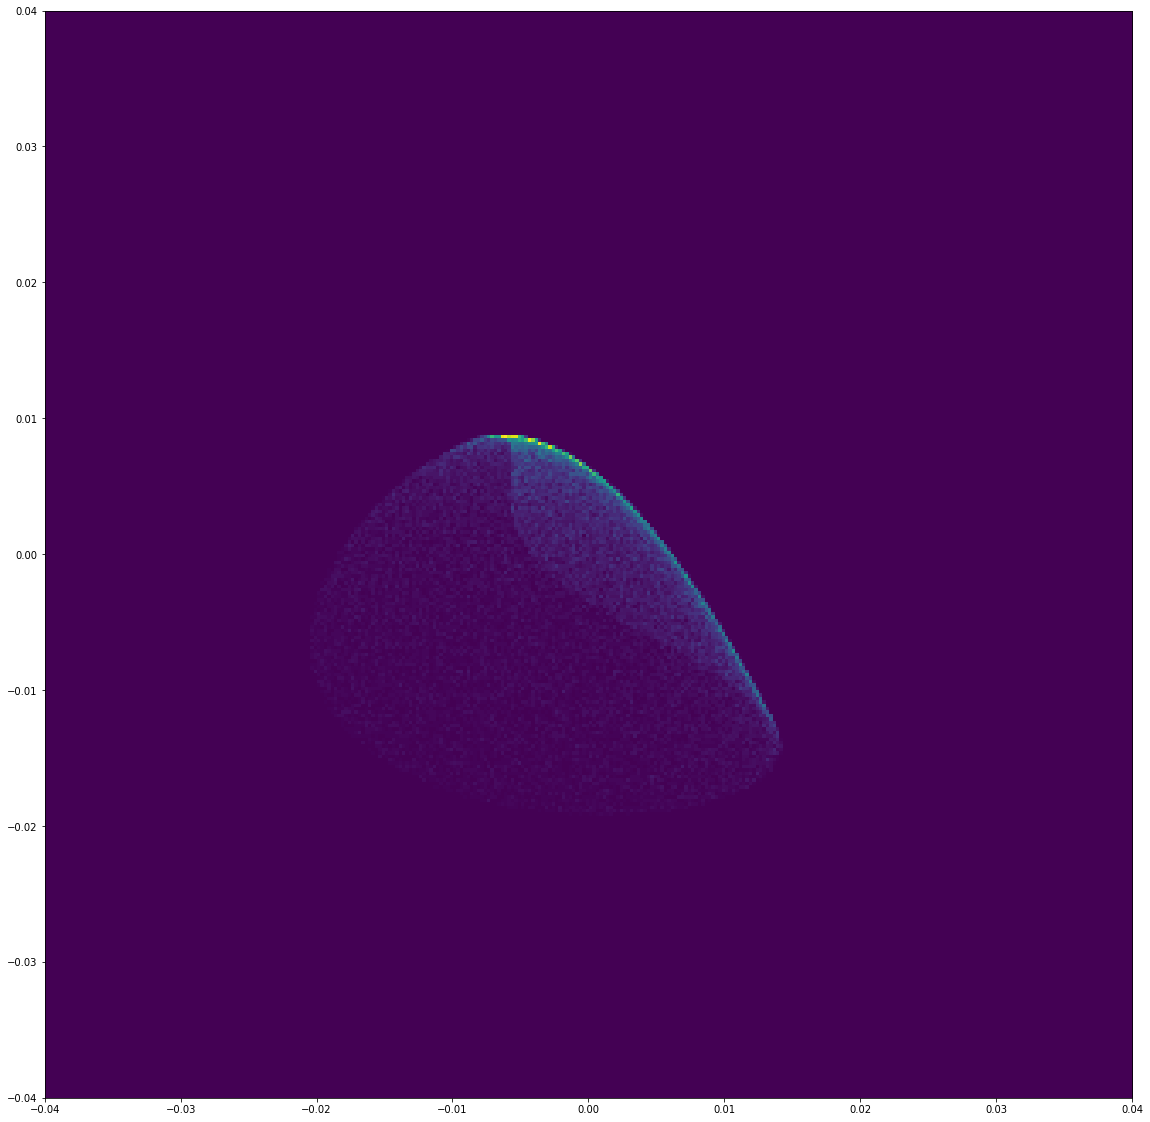

In [514]:
#bins = sensor['npix'],range=sensor['fov']
sensor['px']=.05
yoarr = np.asarray(xo)[:,0]
xoarr = -np.asarray(yo)[:,0]
binedgex = np.r_[:sensor['npix'][1]+1]*sensor['px']
binedgex -= np.mean(binedgex)
binedgey = np.r_[:sensor['npix'][0]+1]*sensor['px']
binedgey -= np.mean(binedgey)   
H,xe, ye = np.histogram2d(xoarr,yoarr,
                          bins=[sensor['npix'][1],sensor['npix'][0]],
                          range=[[-sensor['fov'][1]/2,sensor['fov'][1]/2],[-sensor['fov'][0]/2,sensor['fov'][0]/2]])
plt.figure(figsize=(20,20))
plt.imshow(H, extent=[-sensor['fov'][0]/2,sensor['fov'][0]/2,-sensor['fov'][1]/2,sensor['fov'][1]/2])

In [501]:
def ray2wave(xo,yo,fx,fy,opl,lamb,sensor, Sx, Sy):
    k = 2*np.pi/lamb
    opd = k * opl
    nnorm = np.sqrt(fx**2 + fy**2 + 1)
    kx = -fx*k/nnorm
    ky = -fy*k/nnorm
#    kz = np.sqrt(k**2 - kx**2 - ky **2)

    
    U = np.exp(1j*(kx*(Sx-xo) + ky*(Sy-yo) + opl))
    return U


In [502]:
def drawnow(fig):
    display.clear_output(wait=True)
    display.display(fig)

In [508]:
# Plane waves loop
Nrays = 10000
xo = []
yo = []
opl = []
fx = []
fy = []
dx = []
dy = []
U_accum = np.zeros(sensor['npix']) + 1j*np.zeros(sensor['npix'])
f = plt.figure()
sx = np.linspace(-sensor['fov'][1]/2,sensor['fov'][1]/2,sensor['npix'][1])
sy = np.linspace(-sensor['fov'][0]/2,sensor['fov'][0]/2,sensor['npix'][0])
Sx,Sy = np.meshgrid(sx,sy)
for kk in range(Nrays):
    
    
    # Pick a random location on the surface
    if pupil['ap_type'] == 'circ':
        thx = np.random.rand(1)*2*np.pi
        rho = pupil['ca'][0]/2*np.sqrt(np.random.rand(1))
        rhox = rho*np.sin(thx)
        rhoy = rho*np.cos(thx)
    elif pupil['ap_type'] == 'rect':
        rhox = pupil['ca'][1]*(np.random.rand(1) - 0.5)
        rhoy = pupil['ca'][0]*(np.random.rand(1) - 0.5)

    

    # Launch a ray toward the sensor
    rays_out = trace_ray(rhox, rhoy, pupil)
    xo.append(rays_out[0])
    yo.append(rays_out[1])
    dx.append(xo[kk] - rhox)
    dy.append(yo[kk] - rhoy)
    opl.append(rays_out[2])
    fx.append(rays_out[4])
    fy.append(rays_out[5])
    #print(fx[kk])
    #print(fy[kk])
    U = ray2wave(xo[kk],yo[kk],fx[kk],fy[kk],opl[kk],550e-6,sensor, Sx, Sy)
    
    U_accum += U
    #print(kk)
    #plt.imshow(np.abs(U_accum)**2)
    #drawnow(f)
    # Create the corresponding plane wave on the sensor grid

    # Add this plane wave to the existing distribution

    # Repeat


<Figure size 432x288 with 0 Axes>

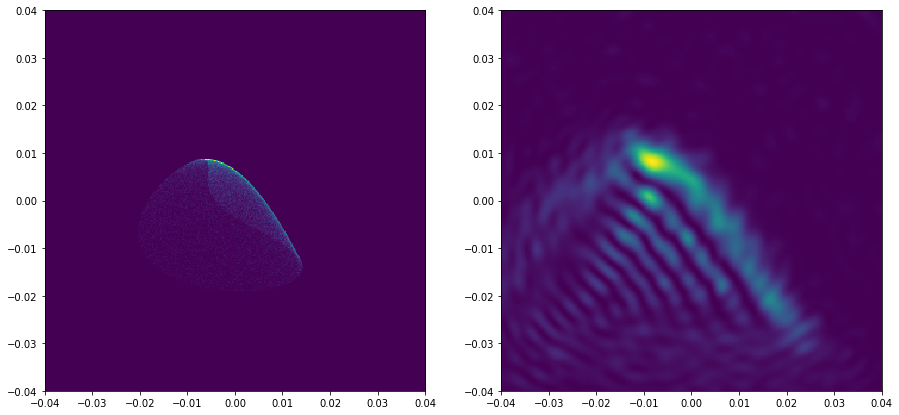

In [515]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))
ax[0].imshow(H, extent=[-sensor['fov'][0]/2,sensor['fov'][0]/2,-sensor['fov'][1]/2,sensor['fov'][1]/2])
ax[1].imshow(np.abs(U_accum[::-1,:])**2,interpolation='none',extent=[-sensor['fov'][0]/2,sensor['fov'][0]/2,-sensor['fov'][1]/2,sensor['fov'][1]/2])